In [1]:
%load_ext autoreload

import os
import sys
sys.path.append('../../..')
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d

import config
import main
import pickle
import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools
from plotting_utils import plot_distortion, download_plot
import seaborn as sns

import matplotlib
matplotlib.rc_file('../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

In [2]:
### SETTINGS TO CHANGE
output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

# Choose to load data (True) or start a new scan (False)
load_data = True

In [3]:
# CMB constraints on interaction rates
input_dir = config.data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [4]:
# f for decay to photons from 1610.06933
f_CLW = np.array([
    [10000, 0.09847589669714873],
    [16058.844238352904, 0.0675647830170246],
    [25788.647827168028, 0.06125016598485203],
    [41413.58785742311, 0.06759326208217092],
    [63095.73444801891, 0.07644789494586095],
    [101324.45716052217, 0.07966189541761039],
    [162715.3675076487, 0.0728108729440447],
    [261302.07419916798, 0.05885197711865242],
    [339960.5877642238, 0.04914961059618436],
    [419620.9308722989, 0.04241347076088932],
    [545937.4126084594, 0.033999242609005144],
    [710278.3406586583, 0.027254277408769012],
    [831763.7711026674, 0.02276005779036828],
    [1026664.5618874491, 0.01869841432818515],
    [1267234.9521044958, 0.015615418750760916],
    [1648704.628438744, 0.012829071368921426],
    [2260922.7001714776, 0.016272679645948106],
    [2647629.082314918, 0.017955363610903368],
    [3268027.5894101122, 0.024922042362227576],
    [4033799.294804449, 0.03402950389398694],
    [5248074.602497712, 0.04387597104728988],
    [6477815.4564042175, 0.05429928396899368],
    [10402622.94191911, 0.06775962937391997],
    [15848931.924611043, 0.06945899905638016],
    [25451552.91215885, 0.06143830811165539],
    [40872252.38405579, 0.05708240831134203],
    [65636113.470619746, 0.052173249922175674],
    [105404012.2635548, 0.045398466107785945],
    [169266661.50378728, 0.038229585855101174],
    [286512026.9663758, 0.03064896842419112],
    [436515832.24016297, 0.025597961934800784],
    [700993975.7519821, 0.020690462964628537],
    [912010839.3559003, 0.0181502054556146],
    [1186549100.0980434, 0.016052829811419513],
    [1543730300.3304071, 0.014081954556520981],
    [2008432048.839189, 0.012660487597537271],
    [2613020741.991669, 0.011570586235969564],
    [4196209308.722972, 0.010927878088782655],
    [10266645618.874493, 0.011296491214206197],
    [16487046284.38744, 0.010845297868158476],
    [21450062968.36389, 0.010158335973518577],
    [121818791201.01048, 0.010249833900252471],
    [158489319246.1098, 0.01310778267797295],
    [254515529121.58746, 0.016627371079877034],
    [408722523840.5563, 0.01400173981062695],
    [656361134706.1947, 0.012693134635857787],
    [999999999999.9918, 0.01269551224723241]
])

In [5]:
# Decay rate constraint from Fig 4 of 2002.03380
Pl2018_rate = np.array([
    [0.000010660504989847922, 1.5203598893748347e-25],
    [0.00001632912685644799, 1.7768361879426514e-25],
    [0.000029663488391777314, 2.0765786185537807e-25],
    [0.00005623413251903491, 2.187335360209185e-25],
    [0.00011364636663857242, 2.3341250443927025e-25],
    [0.00020644996558525567, 2.5897515997442465e-25],
    [0.00035938136638046257, 3.1062942674587646e-25],
    [0.0005623413251903496, 3.8739349796591265e-25],
    [0.0009182542835656282, 5.02327906832849e-25],
    [0.0011859710123376694, 6.103986159383704e-25],
    [0.0013478129649084568, 6.429549377690295e-25],
    [0.0019365871108531847, 7.133694840603744e-25],
    [0.0027825594022071257, 7.133694840603744e-25],
    [0.004172250451890724, 6.429549377690295e-25],
    [0.005994842503189409, 5.222910128125812e-25],
    [0.00807992644838296, 4.0278897440780985e-25],
    [0.00958255854960264, 3.2719720937701037e-25],
    [0.011124904621939366, 2.910943998801704e-25],
    [0.012915496650148827, 2.5563267291827734e-25],
    [0.02296736176338634, 2.159104312375601e-25],
    [0.03998083423884901, 2.1037306139319583e-25],
    [0.06812920690579609, 2.187335360209185e-25],
    [0.12115276586285877, 2.49076562376798e-25],
    [0.22967361763386387, 2.9875648998374637e-25],
    [0.5163723306820099, 4.0278897440780985e-25],
    [0.9582558549602659, 5.155500151429999e-25],
    [1.7040466564250851, 6.346565798979895e-25],
    [2.782559402207126, 7.417196322788822e-25],
    [4.948168092155146, 8.123291106914392e-25],
    [12.115276586285901, 8.556556308858325e-25],
    [21.54434690031882, 8.781779141869895e-25],
    [39.98083423884901, 9.250165570874105e-25],
    [63.90804841860297, 9.371114737249762e-25],
    [118.5971012337673, 8.896603991043262e-25],
    [210.89878321430928, 8.123291106914392e-25],
    [367.1257230035036, 7.514178771936669e-25],
    [726.2917501736191, 7.133694840603744e-25],
    [1319.3814396641435, 7.226970408218022e-25],
    [2555.097090352507, 7.321465586666262e-25],
    [5744.592928245896, 7.321465586666262e-25],
    [8988.841109054572, 7.226970408218022e-25]
])

In [6]:
# Load data
data_list = []
data_list_oldDH = []

# dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/OLD_HL_CMB_anisotropy/'
dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_max_CMB_no_BR_no_distort_TLA/'

directory = os.fsencode(dir_str)
for file in tqdm(sorted(os.listdir(directory))): 
    filename = os.fsdecode(file)
    data_list.append(pickle.load(open(dir_str+filename, 'rb')))

directory = os.fsencode(output_dir+'anisotropy_oldDH/')
for file in tqdm(sorted(os.listdir(directory))): 
    filename = os.fsdecode(file)
    if filename[0:4] == 'phot':
        data_list_oldDH.append(pickle.load(open(output_dir+'anisotropy_oldDH/'+filename, 'rb')))

# Make lists of masses and f_Hion[300]
mDM_list = np.zeros(60)
fHion_list = np.zeros(60)

count = 0
for i, datum in enumerate(data_list):
    if datum['DM_params']['pri'] == 'phot' and datum['DM_params']['DM_process'] == 'decay':
        mDM_list[count] = datum['DM_params']['mDM']
        fHion_list[count] = datum['data']['f']['H ion'][144]
        count+=1

mDM_list_oldDH = np.zeros(60)
fHion_list_oldDH = np.zeros(60)

for ii, datum in enumerate(data_list_oldDH):
    mDM_list_oldDH[ii] = datum['DM_params']['mDM']
    fHion_list_oldDH[ii] = datum['data']['f']['low']['H ion'][144] + datum['data']['f']['high']['H ion'][144]

In [7]:
sort_inds = np.argsort(mDM_list)
mDM_list = mDM_list[sort_inds]
fHion_list = fHion_list[sort_inds]

sort_inds = np.argsort(mDM_list_oldDH)
mDM_list_oldDH = mDM_list_oldDH[sort_inds]
fHion_list_oldDH = fHion_list_oldDH[sort_inds]

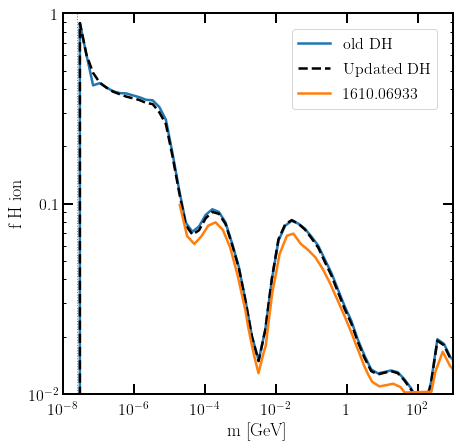

In [9]:
plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(mDM_list_oldDH/1e9, fHion_list_oldDH, label='old DH')
plt.plot(mDM_list/1e9, fHion_list, 'k--', label='Updated DH')
plt.plot(2*f_CLW[:,0]/1e9, f_CLW[:,1], label='1610.06933')
plt.axis([1e-8,1e3,1.e-2,1])
plt.vlines(25.2*1e-9, 1e-3, 10, color='gray', linewidth=1, linestyle=':')
plt.xlabel('m [GeV]')
plt.ylabel('f H ion')
plt.legend()
plt.show()

In [47]:
# Load data over full redshift run
data_list = []
data_list_oldDH = []

directory = os.fsencode(output_dir+'anisotropy_newDH/')
for file in tqdm(sorted(os.listdir(directory))): 
    filename = os.fsdecode(file)
    data_list.append(pickle.load(open(output_dir+'anisotropy_newDH/'+filename, 'rb')))

directory = os.fsencode(output_dir+'anisotropy_oldDH/full_rs/')
for file in tqdm(sorted(os.listdir(directory))): 
    filename = os.fsdecode(file)
    data_list_oldDH.append(pickle.load(open(output_dir+'anisotropy_oldDH/full_rs/'+filename, 'rb')))

mDM_list = np.zeros(10)

for i, datum in enumerate(data_list):
    # print(datum['DM_params']['mDM'], data_list_oldDH[i]['DM_params']['mDM'])
    if datum['DM_params']['pri'] == 'phot' and datum['DM_params']['DM_process'] == 'decay':
        mDM_list[i] = datum['DM_params']['mDM']

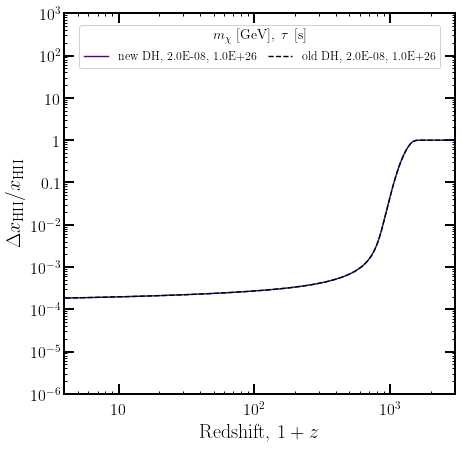

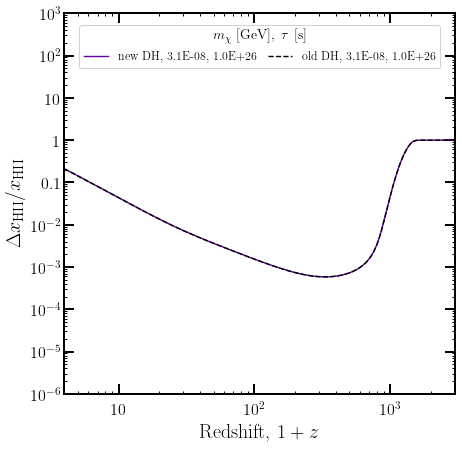

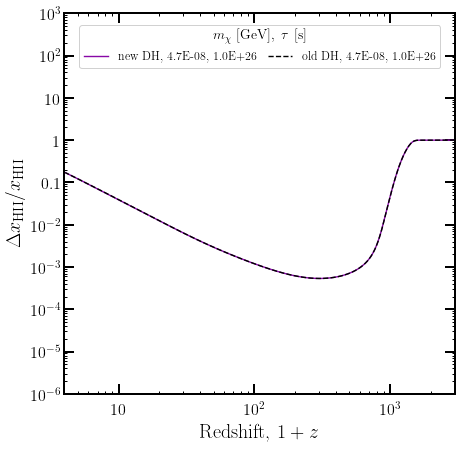

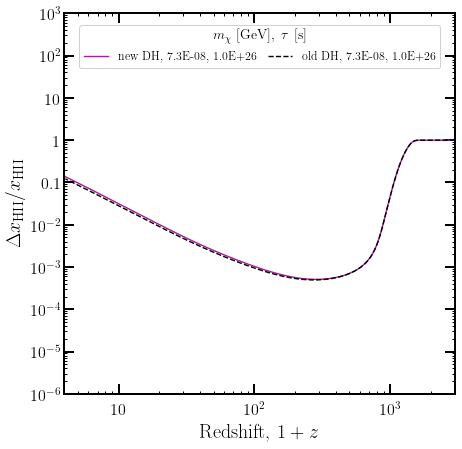

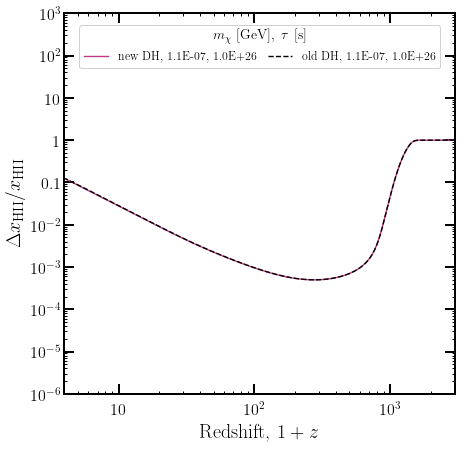

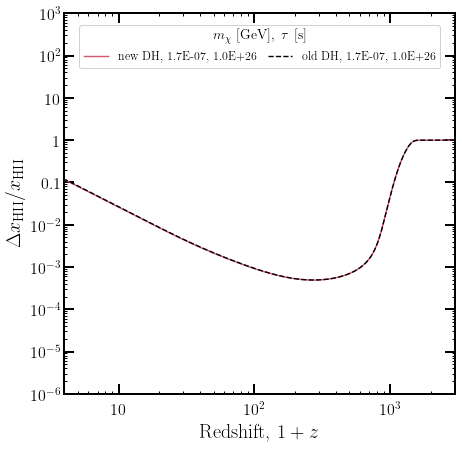

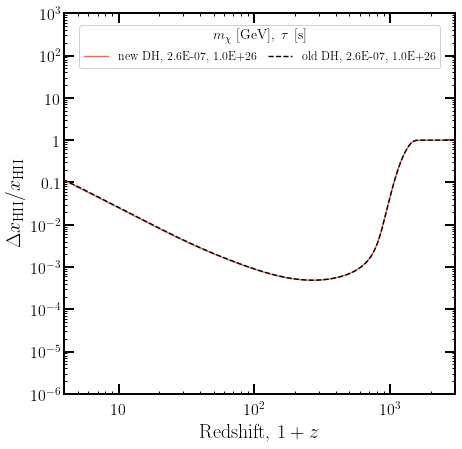

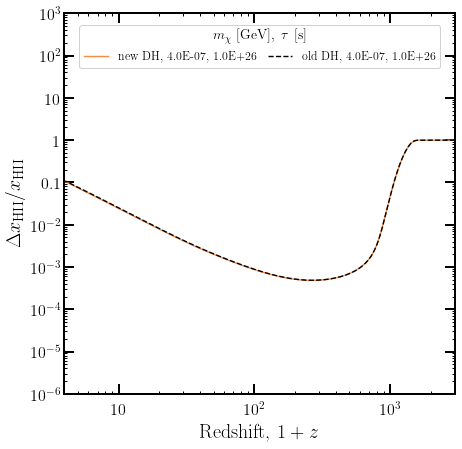

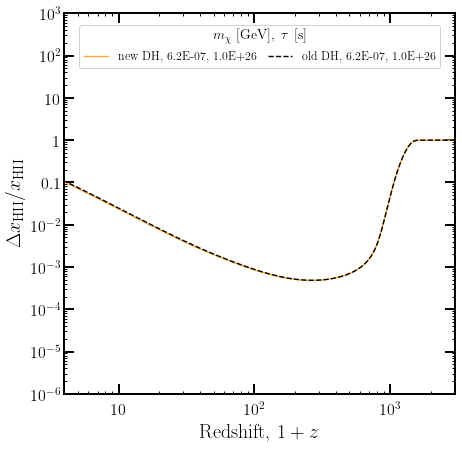

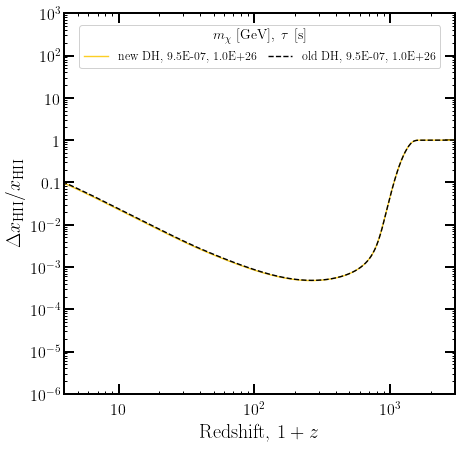

In [54]:
# Ionization histories
cmap = cm.plasma(np.linspace(0.1, 0.9, 10))
for ind in range(10):
    plt.figure(figsize=(7, 7))
    
    plt.xlabel(r'Redshift, $1+z$', fontsize=20)
    plt.ylabel(
        r'$\Delta x_\mathrm{HII} / x_\mathrm{HII}$', 
        fontsize=20
    )
    plt.loglog()
    plt.xlim([4, 3000])
    plt.ylim([1e-6, 1e3])

    plt.plot(
        data_list[ind]['data']['rs'], data_list[ind]['data']['x'][:,0],
        color=cmap[ind], linestyle='solid', linewidth=1.4, 
        label=f"new DH, {data_list[ind]['DM_params']['mDM']/1e9:.1E}, {data_list[ind]['DM_params']['inj_param']:.1E}"
    )
    plt.plot(
        data_list[ind]['data']['rs'], data_list_oldDH[ind]['data']['x'][:,0],
        color='k', linestyle='--', linewidth=1.4, 
        label=f"old DH, {data_list[ind]['DM_params']['mDM']/1e9:.1E}, {data_list[ind]['DM_params']['inj_param']:.1E}"
    )

    plt.legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
                loc='upper center', title_fontsize=14, framealpha=0.9,
                fontsize=12, ncol=2, columnspacing=1)

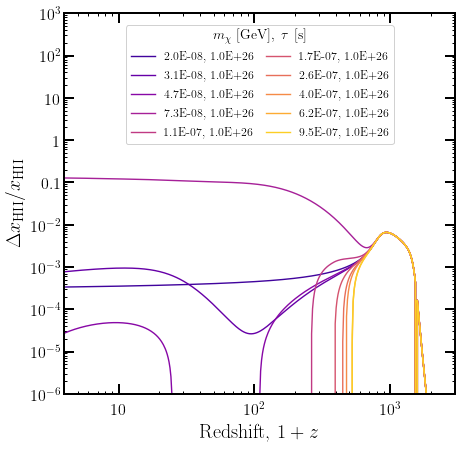

In [43]:
# Relative difference in x_HII to old DH
plt.figure(figsize=(7, 7))
cmap = cm.plasma(np.linspace(0.1, 0.9, 10))

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(
    r'$\Delta x_\mathrm{HII} / x_\mathrm{HII}$', 
    fontsize=20
)
plt.loglog()
plt.xlim([4, 3000])
plt.ylim([1e-6, 1e3])

# plt.text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$', 
#                fontsize = 18, transform = ax.transAxes)
k=0
for ii, data in enumerate(data_list):
    if data['DM_params']['mDM'] <= 1e4:
        plt.plot(
            data['data']['rs'], (data['data']['x'][:,0] - data_list_oldDH[k]['data']['x'][:,0]) / data_list_oldDH[k]['data']['x'][:,0],
            color=cmap[k], linestyle='solid', linewidth=1.4, 
            label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
        )
        k+=1

plt.legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
            loc='upper center', title_fontsize=14, framealpha=0.9,
            fontsize=12, ncol=2, columnspacing=1)

In [8]:
interp_DH = interp1d(mDM_list, fHion_list)
interp_oldDH = interp1d(mDM_list_oldDH, fHion_list_oldDH)
interp_CLW = interp1d(2*f_CLW[:,0], f_CLW[:,1])
scale_CLW = np.mean(decay_phot_CMB(2*f_CLW[:,0]/1e9) / interp_DH(2*f_CLW[:,0]))
print(scale_CLW)

scale_Pl18 = np.mean((1/Pl2018_rate[:-3,1]) / interp_DH(Pl2018_rate[:-3,0]*1e9))
print(scale_Pl18)

# plt.figure(figsize=(7,7))
# plt.xscale('log')
# plt.plot(2*f_CLW[:,0]/1e9, interp_DH(2*f_CLW[:,0]) / interp_CLW(2*f_CLW[:,0]))
# plt.hlines(1.14, 1e-8, 1e3, color='grey', linestyle='--', linewidth=1)
# plt.axis([1e-8,1e3,1,1.4])
# plt.show()

5.030281948042264e+25
6.8623001099227045e+25


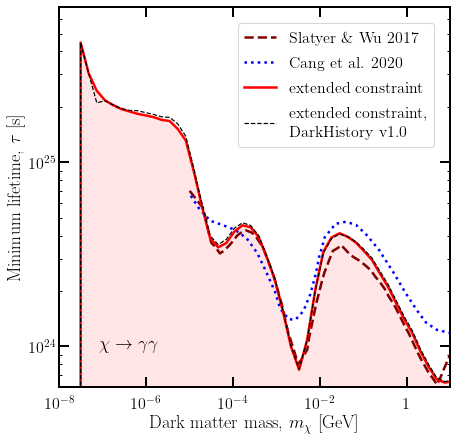

In [16]:
plt.figure(figsize=(7,7))
ax = plt.gca()

plt.loglog()
plt.plot(np.transpose(decay_phot_CMB_raw)[0,:], decay_phot_CMB(np.transpose(decay_phot_CMB_raw)[0,:]), 
            label='Slatyer \& Wu 2017', color='maroon', linestyle='--')
plt.plot(Pl2018_rate[:,0], 1/Pl2018_rate[:,1], 
         label='Cang et al. 2020', color='blue', linestyle=':')
plt.plot(mDM_list/1e9, scale_CLW * fHion_list, 
         label='extended constraint', color='r')
plt.plot(mDM_list_oldDH/1e9, scale_CLW * fHion_list_oldDH, 
         label='extended constraint, \n DarkHistory v1.0', linewidth=1.2, color='k', linestyle='--')
plt.fill_between(mDM_list/1e9, scale_CLW * fHion_list, 1e20,
                 color='r', alpha=0.1)
# plt.plot(mDM_list/1e9, scale_Pl18 * fHion_list, 
#          label='extended constraint', color='b')

plt.axis([1e-8,10,6e23,7e25])
plt.xlabel(r'Dark matter mass, $m_\chi$ [GeV]')
plt.ylabel(r'Minimum lifetime, $\tau$ [s]')
plt.text(0.1, 0.1, r'$\chi \rightarrow \gamma\gamma$', 
         fontsize = 18, transform = ax.transAxes)
plt.legend()
plt.savefig(fig_dir+'anisotropy_constraint.pdf')
plt.show()

## Translate into ALP constraints

In [9]:
tau_list = scale_CLW * fHion_list / phys.hbar # ev^-1
g_list = np.sqrt(
    64 * np.pi / mDM_list**3 / tau_list
)

tau_list_Pl18 = scale_Pl18 * fHion_list / phys.hbar # ev^-1
g_list_Pl18 = np.sqrt(
    64 * np.pi / mDM_list**3 / tau_list_Pl18
)

/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [14]:
def FilledLimit(ax,dat,text_label='',col='ForestGreen',edgecolor='k',
                edgealpha=1,facealpha=1,zorder=1,lw=2,y2=1e0):
    plt.plot(dat[:,0],dat[:,1],'--',color=edgecolor,alpha=edgealpha,zorder=zorder,lw=lw,label=text_label)
    #plt.fill_between(dat[:,0],dat[:,1],y2=y2,edgecolor=None,facecolor=col,alpha=facealpha,zorder=zorder)
    return

dat_xray = np.loadtxt("/Users/viviesque/Documents/Codes/AxionLimits/limit_data/AxionPhoton/XRAY.txt")
dat_ion = np.loadtxt("/Users/viviesque/Documents/Codes/AxionLimits/limit_data/AxionPhoton/x_ion.txt")
dat_EBL = np.loadtxt("/Users/viviesque/Documents/Codes/AxionLimits/limit_data/AxionPhoton/EBL.txt")
dat_LeoT = np.loadtxt("/Users/viviesque/Documents/Codes/AxionLimits/limit_data/AxionPhoton/LeoT.txt")
dat_LeoT[:,1] *= np.sqrt(2)
dat_COBE = np.loadtxt("/Users/viviesque/Documents/Codes/AxionLimits/limit_data/AxionPhoton/COBE-FIRAS.txt")

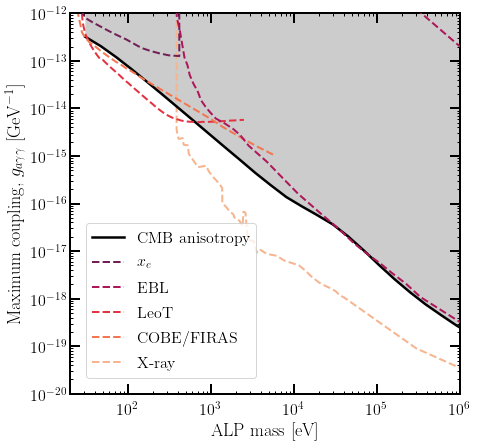

In [15]:
cmap = sns.color_palette("rocket")

fig = plt.figure(figsize=(7,7))
ax = plt.gca()

plt.loglog()
plt.plot(mDM_list, g_list*1e9, color='k', label='CMB anisotropy',zorder=1)
plt.fill_between(mDM_list, g_list*1e9,y2=1,edgecolor=None,facecolor='k',alpha=0.2, zorder=0)
#plt.plot(mDM_list, g_list_Pl18 * 1e9, color='b', label='CMB anisotropy, Pl18',zorder=10)
FilledLimit(ax, dat_ion, text_label=r'$x_e$', col=cmap[1], edgecolor=cmap[1], zorder=3)
FilledLimit(ax, dat_EBL, text_label='EBL', col=cmap[2], edgecolor=cmap[2], zorder=4)
FilledLimit(ax, dat_LeoT, text_label='LeoT', col=cmap[3], edgecolor=cmap[3], zorder=1)
FilledLimit(ax, dat_COBE, text_label='COBE/FIRAS', col=cmap[4], edgecolor=cmap[4], zorder=2)
FilledLimit(ax, dat_xray, text_label='X-ray', col=cmap[5], edgecolor=cmap[5], zorder=0)

plt.axis([20,2*phys.me,1e-20,1e-12])
plt.xlabel(r'ALP mass [eV]')
plt.ylabel(r'Maximum coupling, $g_{a \gamma\gamma}$ [GeV$^{-1}$]')

plt.legend(loc='lower left')
# plt.savefig(fig_dir+'ALP_constraint.pdf')
plt.show()